In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *

from redTools import *
from Kcorrect import *
from calibTools import *

In [2]:
I_maglim = [5807393, 5807403, 5057729, 5059653, 4126669, 5059227, 38803, 39181, 39431, 39619, 39655, 40005, 40107, 40147, 40588, 40604, 41567, 41829, 42768, 41440, 37814, 39344, 13756, 14548, 14590]
calib_maglim = [3974, 6699, 19871, 22277, 38148, 41020, 41066, 41093, 46127, 49448, 53641, 28378, 6699, 9962, 12460, 13163, 22277, 26761, 29128, 38148, 41020, 41066, 44982, 45084, 46127, 49448, 53641, 67908, 72228, 21102, 50073]


In [3]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [44]:
table   = np.genfromtxt('corrected_mags_linewidth_all.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)

catal   = np.genfromtxt('ESN_HI_catal_all.csv' , delimiter=',', 
                        filling_values=-1, names=True, dtype=None, encoding=None)
pgc_catal   = catal['pgc']
R50u_catal  = catal['R50_u']
R50g_catal  = catal['R50_g']
R50r_catal  = catal['R50_r']
R50i_catal  = catal['R50_i']
R50z_catal  = catal['R50_z']
R50w1_catal = catal['R50_w1']
R50w2_catal = catal['R50_w2']
Sba_catal   = catal['Sba']
Wba_catal   = catal['Wba']

pgc_tab = table['pgc']
u_tab   = table['u_sss']
g_tab   = table['g_sss']
r_tab   = table['r_sss']
i_tab   = table['i_sss']
z_tab   = table['z_sss']
w1_tab  = table['w1_sss']
w2_tab  = table['w2_sss']
m21_tab = table['m21']
inc_tab = table['inc']
Sqlt = table['Sqlt']
Wqlt = table['Wqlt']
logWimx   = table['logWimx']
logWimx_e = table['logWimx_e']
Vhel = table['Vhel']
Vls = table['Vls']


N = len(pgc_tab)
inc  = np.zeros(N)
m21  = np.zeros(N)
Sba  = np.zeros(N)
Wba  = np.zeros(N)

uuu  = np.zeros(N)
ggg  = np.zeros(N)
rrr  = np.zeros(N)
iii  = np.zeros(N)
zzz  = np.zeros(N)
w11  = np.zeros(N)
w22  = np.zeros(N)

R50u  = np.zeros(N)
R50g  = np.zeros(N)
R50r  = np.zeros(N)
R50i  = np.zeros(N)
R50z  = np.zeros(N)
R50w1 = np.zeros(N)
R50w2 = np.zeros(N)

SSqlt = np.zeros(N)
WWqlt = np.zeros(N)

for i, idd in enumerate(pgc_tab):
    if idd in pgc_catal:
        indx,   = np.where(pgc_catal==idd)
        R50u[i]  = R50u_catal[indx][0]
        R50g[i]  = R50g_catal[indx][0]
        R50r[i]  = R50r_catal[indx][0]
        R50i[i]  = R50i_catal[indx][0]
        R50z[i]  = R50z_catal[indx][0]
        R50w1[i] = R50w1_catal[indx][0]
        R50w2[i] = R50w2_catal[indx][0]
        Sba[i]   = Sba_catal[indx][0]
        Wba[i]   = Wba_catal[indx][0]

    if idd in pgc_tab:
        indx,  = np.where(pgc_tab==idd)    
        inc[i] = inc_tab[indx][0]
        uuu[i] = u_tab[indx][0]
        ggg[i] = g_tab[indx][0]
        rrr[i] = r_tab[indx][0]
        iii[i] = i_tab[indx][0]
        zzz[i] = z_tab[indx][0]
        w11[i] = w1_tab[indx][0]
        w22[i] = w2_tab[indx][0]
        m21[i] = m21_tab[indx][0]   
        SSqlt[i] = Sqlt[indx][0]   
        WWqlt[i] = Wqlt[indx][0]   
    
    
    
mu50_u  = uuu+2.5*np.log10(2.*np.pi*(R50u*60)**2)-2.5*np.log10(Sba)
mu50_g  = ggg+2.5*np.log10(2.*np.pi*(R50g*60)**2)-2.5*np.log10(Sba)
mu50_r  = rrr+2.5*np.log10(2.*np.pi*(R50r*60)**2)-2.5*np.log10(Sba)
mu50_i  = iii+2.5*np.log10(2.*np.pi*(R50i*60)**2)-2.5*np.log10(Sba)
mu50_z  = zzz+2.5*np.log10(2.*np.pi*(R50z*60)**2)-2.5*np.log10(Sba)
m21_u   = m21 - uuu
m21_g   = m21 - ggg
m21_r   = m21 - rrr
m21_i   = m21 - iii
m21_z   = m21 - zzz


mu50_w1  = w11+2.5*np.log10(2.*np.pi*(R50w1*60)**2)-2.5*np.log10(Wba)
mu50_w2  = w22+2.5*np.log10(2.*np.pi*(R50w2*60)**2)-2.5*np.log10(Wba)
m21_w1   = m21 - w11
m21_w2   = m21 - w22

u_i   = uuu-iii
g_i   = ggg-iii
r_i   = rrr-iii
i_z   = iii-zzz
g_z   = ggg-zzz
i_w1  = iii-w11
i_w2  = iii-w22
r_z   = rrr-zzz
g_r   = ggg-rrr
r_z   = rrr-zzz

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in subtract
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log10
/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: invali

In [5]:
####################################
def TFRcurve(logW, slope, zp, A, band):


    if band in ['w1', 'w2']:
        logW0=2.4 
    else:
        logW0=2.5

    X0 = logW0 - 2.5
    X = logW-2.5
    B = -2.*A*X0
    M = slope*X+(zp)
    delta = ((A*X**2+B*X) - (A*X0**2+B*X0))

    try:
        delta[np.where(logW<logW0)] = 0
    except:
        if logW<logW0:
            delta = 0

    return M+delta
####################################

def DMcalc(logW, mag, band='i', deltaDM=0, dlogW=None):
    
    dmag = 0.05
    ds=0; dzp=0
    if band=='u':
        dmag = 0.1
        slope=-7.03 ; zp=-19.27; Czp=-0.08; A2=6.59
        ds = 0.17 ; dzp = 0.13
    elif band=='g':
        slope=-7.37 ; zp=-20.15; Czp=-0.11; A2=4.18
        ds = 0.13 ; dzp = 0.11
    elif band=='r':
        slope=-7.96 ; zp=-20.57; Czp=-0.08; A2=4.56   
        ds = 0.13 ; dzp = 0.10
    elif band=='i':
        slope=-8.32 ; zp=-20.80; Czp=-0.04; A2=5.34
#         Czp=-0.1;# A2=0
        ds = 0.13 ; dzp = 0.10
    elif band=='z':
        slope=-8.46 ; zp=-20.89; Czp=-0.08; A2=5.81 
        ds = 0.13 ; dzp = 0.10
    elif band=='w1':
        slope=-9.47 ; zp=-20.36; Czp=0.0; A2=3.81
        ds = 0.14 ; dzp = 0.07
    elif band=='w2':
        slope=-9.66 ; zp=-19.76; Czp=0.0; A2=4.42
        ds = 0.14 ; dzp = 0.07
        
        
#     MAG = TFRcurve(logW, slope, zp, A2, band) + Czp
    MAG = slope*(logW-2.5) + zp
    DM = (mag-MAG) + deltaDM
    
    if not dlogW is None:
        dMAG2 = (slope*dlogW)**2 + dzp**2# + (ds*(logW-2.5))**2
#         dDM = np.sqrt(dmag**2+dMAG2)
        dDM = np.sqrt(dMAG2)
        
#         dDM = np.abs(slope*dlogW)
        
        return DM, dDM
    else:
        return DM
    
################################### 

In [40]:
DM_u, dDM_u = DMcalc(logWimx, uuu, band='u', deltaDM=0, dlogW=logWimx_e)
DM_g, dDM_g = DMcalc(logWimx, ggg, band='g', deltaDM=0, dlogW=logWimx_e)
DM_r, dDM_r = DMcalc(logWimx, rrr, band='r', deltaDM=0, dlogW=logWimx_e)
DM_i, dDM_i = DMcalc(logWimx, iii, band='i', deltaDM=0, dlogW=logWimx_e)
DM_z, dDM_z = DMcalc(logWimx, zzz, band='z', deltaDM=0, dlogW=logWimx_e)

DM_1, dDM_1 = DMcalc(logWimx, w11, band='w1', deltaDM=0, dlogW=logWimx_e)
DM_2, dDM_2 = DMcalc(logWimx, w22, band='w2', deltaDM=0, dlogW=logWimx_e)

In [45]:
table = pd.read_fwf('DMi_V_m17rev.6616.spgc')
# table = pd.read_fwf('DMW1_V_m161rev.5065.spgc')

pgc_b = np.asarray(table['PGC'])
Vmod = np.asarray(table['Vmod'])
dmi = np.asarray(table['dmi'])
edmi = np.asarray(table['edmi'])


pgc_b.shape

(6616,)

In [46]:
table   = np.genfromtxt('Clusters_i.csv' , delimiter='|', 
                        filling_values=-1, names=True, dtype=None, encoding=None)


pgc_i = table['pgc']
Cname = table['Cluster']

pgc_i.shape

(430,)

In [54]:
logH = Vmod*0.
elogW = Vmod*0.
logW = Vmod*0.
dDM = Vmod*0.

incL = Vmod*0.

# DM_clusters = {}
# for i, idd in enumerate(pgc_i):
for i, idd in enumerate(pgc_b):
    
    if idd in pgc_tab:
        j, = np.where(pgc_tab==idd)

        logD = (DM_i[j][0]-25)/5.
        elogW[i] = logWimx_e[j][0]
        logW[i] = logWimx[j][0]
        dDM[i] = dDM_i[j][0]
    #     dDM[i] = edmi[i]
    #     logD = (dmi[i]-25)/5.

    #     ClusterName = Cname[i].strip()

    #     if True: #idd in pgc_b:
    #         k, = np.where(pgc_b==idd)
    #         logH[i] = np.log10(Vmod[k][0]) - logD
    #         dDM[i] = edmi[k][0]

    #         print DM_i[j][0]
    #         if ClusterName in DM_clusters:
    #             DM_clusters[ClusterName].append(DM_i[j][0])
    #         else:
    #             DM_clusters[ClusterName] = [DM_i[j][0]]


        logH[i] = np.log10(Vmod[i]) - logD   
        incL[i] = inc[j][0]
    

In [49]:
for key in DM_clusters:
    
    ave = np.mean(DM_clusters[key])
    std = np.std(DM_clusters[key])
    print key, "\t\t\t%.2f"%ave, "%.2f"%std
    

NGC507 			33.86 0.53
Abell 1367 			34.65 0.55
NGC70 			34.58 0.34
Cancer 			33.97 0.46
Abell 2634/66 			35.09 0.46
NGC4065 			35.11 0.39
NGC80 			34.36 0.39
Abell 400 			34.55 0.52
Virgo 			30.66 0.67
Pegasus 			33.16 0.58
Abell 2151 (Hercules) 			35.76 0.41
Coma 			34.68 0.55
Ursa Major 			31.15 0.52
NGC410 			33.84 0.51


In [50]:
def add2Dict0(myDict, code, band, Mlim):
    
    if not code in myDict:
        myDict[code]={}
    myDict[code][band]= Mlim
    



def add2Dict(myDict, code, band, param, DM):
    
    if not code in myDict:
        myDict[code]={}
    if not band in myDict[code]:
        myDict[code][band]={}
    if not param in myDict[code][band]:
        myDict[code][band][param]={}
    myDict[code][band][param] = DM
##############################################   
table   = np.genfromtxt('cluster_code_Mlimit_revised.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)

mag_lims_u = table['u']
mag_lims_g = table['g']
mag_lims_r = table['r']
mag_lims_i = table['i']
mag_lims_z = table['z']
mag_lims_w1 = table['w1']
mag_lims_w2 = table['w2']
code = table['Code']  
Mlim_dict = {} 

for i, myCode in enumerate(code):
    myCode = myCode.strip()
    add2Dict0(Mlim_dict, myCode, 'u', mag_lims_u[i])
    add2Dict0(Mlim_dict, myCode, 'g', mag_lims_g[i])
    add2Dict0(Mlim_dict, myCode, 'r', mag_lims_r[i])
    add2Dict0(Mlim_dict, myCode, 'i', mag_lims_i[i])
    add2Dict0(Mlim_dict, myCode, 'z', mag_lims_z[i])
    add2Dict0(Mlim_dict, myCode, 'w1', mag_lims_w1[i])
    add2Dict0(Mlim_dict, myCode, 'w2', mag_lims_w2[i])
    
##############################################
table   = np.genfromtxt('cluster_DM_code.csv' , delimiter=',', 
                        filling_values=0, names=True, dtype=None, encoding=None)
DM_band = table['band']
DM_param = table['param']
DM_code = table['Code']
DM_cluster = table['Cluster']
DM_Ngal = table['Ngal']
DM = table['DM']
DMe = table['DMe']
##############################################
    
DM_Dict = {}    
for i, myCode in enumerate(DM_code):
    add2Dict(DM_Dict, myCode.strip(), DM_band[i].strip(), DM_param[i].strip(), np.float(DM[i]))  

-0.1227983690028222


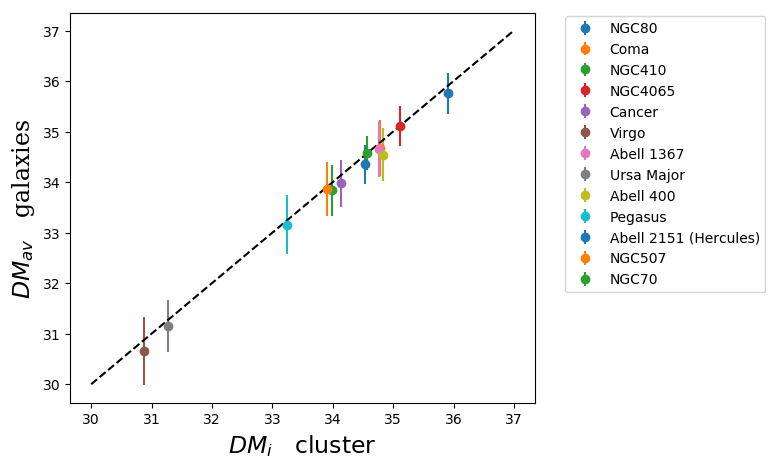

In [51]:
def convertKey(key):
    
    if key=='N8': return "NGC80"
    if key=='Hy': return "Hydra"
    if key=='Co': return "Coma"
    if key=='A26': return "Abell 2634/66"
    if key=='F': return "Fornax"
    if key=='N41': return "NGC410"
    if key=='N40': return "NGC4065"
    if key=='Ca': return "Cancer"
    if key=='V': return "Virgo"
    if key=='Ce': return "Centaurus"
    if key=='An': return "Antlia"
    if key=='A1': return "Abell 1367"
    if key=='A2': return "Abell 262"
    if key=='Pe': return "Pegasus"
    if key=='A5': return "Abell 539"
    if key=='He': return "Abell 2151 (Hercules)"
    if key=='N5': return "NGC507"
    if key=='N7': return "NGC70"
    if key=='U': return "Ursa Major"
    if key=='A4': return "Abell 400"
    return None


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

dDM = [] 

for key in DM_Dict:
    if 'i' in DM_Dict[key]:
        ClusterName = convertKey(key)
        if ClusterName in DM_clusters and not ClusterName=='Abell 262':
        
            ave = np.mean(DM_clusters[ClusterName])
            std = np.std(DM_clusters[ClusterName])

            ax.errorbar(DM_Dict[key]['i']['a'], ave, yerr=std, fmt='o', label=ClusterName)
            dDM.append(ave - DM_Dict[key]['i']['a'])

ax.plot([30,37],[30,37], 'k--')
ax.legend(loc=2, bbox_to_anchor=(1.05, 1.01))

font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

ax.set_ylabel(r'$DM_{av}$'+ '   galaxies', fontsize=17, fontdict=font)
ax.set_xlabel(r'$DM_i$' + '   cluster', fontsize=17)


print np.mean(dDM)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f3b95b54e90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3b9489a350>)

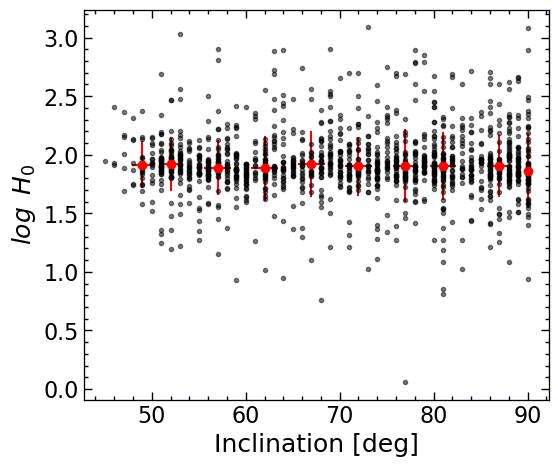

In [73]:
table = pd.read_fwf('DMi_V_m17rev.6616.spgc')
# table = pd.read_fwf('DMW1_V_m161rev.5065.spgc')

pgc_b = np.asarray(table['PGC'])
Vmod = np.asarray(table['Vmod'])
dmi = np.asarray(table['dmi'])
edmi = np.asarray(table['edmi'])


pgc_b.shape

indx, = np.where((logH<3.2) & (logH>0))


fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


# plt.plot(Vmod[indx], logH[indx], 'k.', alpha=0.5)
# plt.plot(Vmod, logH, 'k.', alpha=0.5)




ax.plot(incL[indx], logH[indx], 'k.', alpha=0.5)



X = incL[indx]
Y = logH[indx]
for i in np.arange(45, 95,5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     

ax.set_xlabel('Inclination [deg]', fontsize=18) 
ax.set_ylabel(r'$log \/\/\/ H_0$', fontsize=18) 

set_axes(ax)

In [33]:
print(10**np.mean(logH[np.where((Vmod>0) & (logH<3)& (logH>0) & (logW>1.))]))


83.55400935589856


In [15]:
len(pgc_tab)

10736

In [16]:
print len(logH)

6616


In [17]:
len(logH), len(elogW)

(6616, 6616)

In [23]:
indx, = np.where((Vmod>0) & (logH<3)& (logH>0))
lH  = logH[indx]
elW = elogW[indx]
# emi = dDM[indx]

In [24]:
len(lH), len(elW), len(emi)

NameError: name 'emi' is not defined

In [25]:
10**(np.sum(lH/elW**1)/np.sum(1./elW**1))

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

In [21]:
10**(np.sum(lH/elW**2)/np.sum(1./elW**2))

/home/ehsan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

In [22]:
10**(np.sum(lH/emi**1)/np.sum(1./emi**1))

NameError: name 'emi' is not defined

In [ ]:
10**(np.sum(lH/emi**2)/np.sum(1./emi**2))

In [ ]:
print 10**np.mean(lH)
print np.mean(10**lH)

In [ ]:
10**(np.sum(lH*emi**1)/np.sum(1.*emi**1))

In [ ]:
10**(np.sum(lH*emi**2)/np.sum(1.*emi**2))

In [ ]:
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod

In [ ]:
i = 120
v_cmb = Vh2V3k(gl[i], gb[i], Vh[i])
v_mod = Vcmb2Vmod(v_cmb)

print v_mod , Vmod[i]

In [ ]:
DMi_brent = pd.read_fwf('DMi_V_m17rev.6616.spgc')
DMw1_brent = pd.read_fwf('DMW1_V_m161rev.5065.spgc')

In [ ]:
np.asarray(DMi_brent['PGC'])